### 숫자예측 모델(LSTM)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
# 1. 데이터 생성 (랜덤 숫자 시퀀스)
data = np.array([i for i in range(1, 21)])  # 1부터 20까지의 숫자
timesteps = 3  # 타임스텝 길이

In [ ]:
x_data = []
y_data = []

In [ ]:
# 타임스텝에 따라 입력 데이터와 출력 데이터 생성
for i in range(len(data) - timesteps):
    x_data.append(data[i:i + timesteps])  # 입력 (3개의 숫자)
    y_data.append(data[i + timesteps])   # 출력 (다음 숫자)

x_data = np.array(x_data).reshape(-1, timesteps, 1)  # (샘플 수, 타임스텝, 피처 수)
y_data = np.array(y_data)  # 출력값

In [ ]:
# 2. LSTM 모델 정의
model = Sequential([
    LSTM(10, input_shape=(timesteps, 1)),  # LSTM 레이어 (유닛: 10)
    Dense(1)  # 출력 레이어
])

In [ ]:
model.compile(optimizer='adam', loss='mse')

In [ ]:
# 3. 모델 학습
model.fit(x_data, y_data, epochs=1000, verbose=1)  # 100번 반복 학습

In [ ]:
# 4. 예측 테스트
test_input = np.array([18, 19, 20]).reshape(1, timesteps, 1)  # 입력 예시
predicted_value = model.predict(test_input)

In [ ]:
# 결과 출력
print("입력 데이터:", test_input.flatten()) # flatten함수 : [[1,2],[3,4]] --> [1,2,3,4]
print("예측 값:", predicted_value[0][0])

### 기온예측 모델(RNN)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

In [ ]:
# 1. 데이터 로드
file_path = "dataset/jena_climate_2009.csv"
data = pd.read_csv(file_path)

In [ ]:
# 데이터 확인
data.head()

In [ ]:
# 'T (degC)' 열이 기온 데이터
temperature = data['T (degC)'].values

In [ ]:
# 2. 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))  # 정규화
scaled_data = scaler.fit_transform(temperature.reshape(-1, 1))

In [ ]:
# 데이터셋 생성 함수
def create_dataset(dataset, look_back=60):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

In [ ]:
look_back = 60  # 과거 60시간 데이터를 기반으로 예측
X, y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # RNN 입력 형태

In [ ]:
# 데이터 분리
train_size = int(len(X) * 0.8)  # 80% 학습 데이터
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# 3. RNN 모델 구성
model = Sequential([
    SimpleRNN(50, return_sequences=False, input_shape=(X.shape[1], 1)),  # 50(뉴런 즉 메모리유닛수), return_sequence=False(마지막시점 출력만 반환)
    Dense(1)
])

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# 4. 모델 학습
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

In [ ]:
# 5. 예측
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # 정규화 복원

In [ ]:
# 실제 값 복원
actual_values = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# 6. 시각화
plt.figure(figsize=(14, 5))
plt.plot(actual_values, label="Actual Temperature", color='blue')
plt.plot(predictions, label="Predicted Temperature", color='red')
plt.title('Temperature Prediction using RNN')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

In [ ]:
# 7. 학습 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 주가예측 모델(LSTM)

In [ ]:
# 증권데이터 수집 라이브러리 설치 :  pip install yfinance
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
# 1. 데이터 수집
ticker = "AAPL"  # 예: 애플 주식
data = yf.download(ticker, start="2015-01-01", end="2024-01-01")
data = data[['Close']]  # 종가만 사용

In [ ]:
data.head()

In [ ]:
# 2. 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [ ]:
def create_dataset(dataset, look_back=60):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

In [ ]:
look_back = 60  # 과거 60일 데이터로 예측
X, y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # LSTM 입력 형태

In [ ]:
# 3. 모델 구성
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    LSTM(50),
    Dense(1)
])

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# 4. 모델 학습
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

In [ ]:
# 5. 예측 및 시각화
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

In [ ]:
# 실제 값 복원
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# 시각화
plt.figure(figsize=(14, 5))
plt.plot(actual_prices, label="Actual Prices", color='blue')
plt.plot(predictions, label="Predicted Prices", color='red')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

### 주가예측 모델(GRU)

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

In [ ]:
# 1. 데이터 수집
ticker = "AAPL"  # 애플 주식
data = yf.download(ticker, start="2015-01-01", end="2024-01-01")
data = data[['Close']]  # 종가 데이터만 사용

In [ ]:
# 2. 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))  # 데이터를 0~1 사이로 정규화
scaled_data = scaler.fit_transform(data)

In [ ]:
# GRU 모델에 적합한 데이터셋 생성 함수
def create_dataset(dataset, look_back=60):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

In [ ]:
look_back = 60  # 과거 60일 데이터로 예측
X, y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # GRU 입력 형태

In [ ]:
# 3. GRU 모델 구성
model = Sequential([
    GRU(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    GRU(50),
    Dense(1)
])

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# 4. 모델 학습
train_size = int(len(X) * 0.8)  # 80% 학습 데이터, 20% 테스트 데이터
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

In [ ]:
# 5. 예측
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))  # 정규화 복원

In [ ]:
# 실제 값 복원
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# 6. 시각화
plt.figure(figsize=(14, 5))
plt.plot(actual_prices, label="Actual Prices", color='blue')
plt.plot(predictions, label="Predicted Prices", color='red')
plt.title(f'{ticker} Stock Price Prediction using GRU')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

### 항공기 탑승객 수요 예측(LSTM)

In [ ]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
# 데이터 불러오기
data_path = 'dataset/airline.csv'  # 데이터 경로
df = pd.read_csv(data_path)

In [ ]:
# 데이터 확인
print(df.head())

In [ ]:
# 날짜(Date)와 탑승객 수(count) 열의 이름 설정 및 변환
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [ ]:
# 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(df['count'], label='Passenger Count')
plt.title('Monthly Airline Passenger Numbers')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

In [ ]:
# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['count']])

In [ ]:
# 데이터셋 분리 (학습 데이터와 테스트 데이터)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [ ]:
# 시계열 데이터셋 생성 함수
def create_dataset(data, time_step=12):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step])
        y.append(data[i+time_step])
    return np.array(X), np.array(y)

In [ ]:
time_step = 12  # 12개월 단위로 예측
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
# LSTM 입력에 맞게 데이터 형태 변경
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# LSTM 모델 생성
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# 모델 학습
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)

In [ ]:
# 학습 과정 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# 테스트 데이터 예측
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [ ]:
# 예측값 역정규화
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index[:len(y_train)], y_train, label='Actual Train Data')
plt.plot(df.index[time_step:len(train_predict) + time_step], train_predict, label='Train Prediction')
plt.plot(df.index[len(train_data):len(train_data) + len(test_predict)], y_test, label='Actual Test Data')
plt.plot(df.index[len(train_data):len(train_data) + len(test_predict)], test_predict, label='Test Prediction')
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

### 자전거 대여량 예측(GRU)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.model_selection import train_test_split

In [ ]:
# 1. 데이터 불러오기
dataset_path = './dataset/'
train_data = pd.read_csv(dataset_path + 'train.csv')
test_data = pd.read_csv(dataset_path + 'test.csv')

In [ ]:
# 2. 데이터 전처리
def preprocess_data(data):
    data['datetime'] = pd.to_datetime(data['datetime'])
    data['hour'] = data['datetime'].dt.hour
    data['day'] = data['datetime'].dt.day
    data['month'] = data['datetime'].dt.month
    data['year'] = data['datetime'].dt.year

    data = data.drop(['datetime', 'casual', 'registered'], axis=1, errors='ignore')
    return data

In [ ]:
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

In [ ]:
# Feature와 Target 분리
X = train_data.drop(['count'], axis=1).values
y = train_data['count'].values.reshape(-1, 1)

In [ ]:
# MinMaxScaler를 사용하여 데이터 정규화
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [ ]:
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

In [ ]:
# Train/Test 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 3. 데이터 차원 조정 (GRU 입력 형태로 변환)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

In [ ]:
# 4. GRU 모델 생성
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(1)
])

In [ ]:
model.compile(optimizer='adam', loss='mse')

In [ ]:
# 5. 모델 학습
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)


In [ ]:
# 6. 학습 과정 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# 7. 테스트 데이터 예측
X_test = scaler_X.transform(test_data.values)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

y_pred = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)

In [ ]:
# 결과 저장
test_data['predicted_count'] = y_pred
test_data.to_csv(dataset_path + 'test_predictions.csv', index=False)
print("예측 결과가 'test_predictions.csv'로 저장되었습니다.")

### 꽃 이미지 분류 및 예측 예제(CNN)

In [ ]:
# flower_photo 디렉토리 밑에 daisy, dandelion, roses, sunflowers, tulips 디렉토리 존재, 약 3670개 사진
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import os
import pathlib
import urllib.request
import tarfile

In [ ]:
# 데이터 다운로드 함수
def download_and_extract_data():
    # 데이터 URL
    dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

    # 다운로드할 디렉토리 생성
    download_dir = os.path.join(os.getcwd(), 'flower_dataset')
    os.makedirs(download_dir, exist_ok=True)

    # 파일 다운로드
    tgz_path = os.path.join(download_dir, "flower_photos.tgz")

    if not os.path.exists(tgz_path):
        print("데이터셋 다운로드 중...")
        urllib.request.urlretrieve(dataset_url, tgz_path)
        print("다운로드 완료!")

    # 압축 해제
    if not os.path.exists(os.path.join(download_dir, "flower_photos")):
        print("압축 해제 중...")
        with tarfile.open(tgz_path) as tar:
            tar.extractall(path=download_dir)
        print("압축 해제 완료!")

    return os.path.join(download_dir, "flower_photos")

In [ ]:
# 데이터 다운로드 및 경로 설정
data_dir = download_and_extract_data()
data_dir = pathlib.Path(data_dir)

In [ ]:
# 클래스 및 이미지 개수 확인
classes = sorted([item.name for item in data_dir.glob('*/') if item.is_dir()])
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f"발견된 클래스: {classes}")
print(f"총 이미지 개수: {image_count}")

In [ ]:
# 각 클래스별 이미지 개수 확인
for class_name in classes:
    class_images = len(list(data_dir.glob(f'{class_name}/*')))
    print(f"{class_name}: {class_images}개 이미지")

In [ ]:
# 이미지 크기 및 배치 크기 설정
img_height = 180
img_width = 180
batch_size = 32

In [ ]:
# 훈련 데이터셋 생성
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    str(data_dir),
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

In [ ]:
# 검증 데이터셋 생성
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    str(data_dir),
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

In [ ]:
# 클래스 이름 확인
class_names = train_ds.class_names
print("클래스:", class_names)
num_classes = len(class_names)

In [ ]:
# 데이터셋 성능 최적화
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# 데이터 증강 레이어 정의
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

In [ ]:
# 샘플 이미지 시각화
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [ ]:
# CNN 모델 구성
model = tf.keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# 모델 컴파일
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
# 모델 구조 출력
model.summary()

In [ ]:
# Early Stopping 콜백 설정
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
]

In [ ]:
# 모델 학습
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

In [ ]:

# 학습 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# 모델 저장
model.save('./model/flower_classification_model.h5')
print("모델이 'flower_classification_model.h5'로 저장되었습니다.")

In [ ]:
# 저장된 모델 불러오기
from tensorflow.keras.models import load_model

In [ ]:
model_path = './model/flower_classification_model.h5'  # 저장된 모델 경로
loaded_model = load_model(model_path)
print("저장된 모델이 성공적으로 로드되었습니다.")

In [ ]:
# 저장된 모델을 활용한 이미지 예측 함수
def predict_flower_with_loaded_model(img_path, model, class_names):
    """
    이미지 경로와 모델을 입력받아 예측 결과를 출력하고 이미지를 시각화하는 함수.

    Parameters:
        img_path (str): 예측할 이미지 파일 경로.
        model (tf.keras.Model): 저장된 모델.
        class_names (list): 클래스 이름 리스트.
    """
    # 이미지 로드 및 전처리
    img = tf.keras.preprocessing.image.load_img(
        img_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # 배치 차원 추가

    # 예측 수행
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    # 예측 결과 출력
    print(
        "이 이미지는 '{}' ({:.2f}% 확률) 입니다."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

    # 이미지 시각화
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
# 테스트 이미지 경로
#test_image_path = './flower_dataset/flower_photos/daisy/5547758_eea9edfd54_n.jpg'
test_image_path = './flower_dataset/flower_photos/roses/12240303_80d87f77a3_n.jpg'

In [ ]:
# 예측 실행
predict_flower_with_loaded_model(test_image_path, loaded_model, class_names)

### 클러스터링 예제(k-means)

In [ ]:
import os
os.environ['OMP_NUM_THREADS'] ='1'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
dataset = pd.read_csv('./dataset/KMeansData.csv')
dataset[:5]

,hour,score
0,7.33,73
1,3.71,55
2,3.43,55
3,3.06,89
4,3.33,79


In [ ]:
X = dataset.iloc[:,:].values
X[:5]

array([[ 7.33, 73.  ],
       [ 3.71, 55.  ],
       [ 3.43, 55.  ],
       [ 3.06, 89.  ],
       [ 3.33, 79.  ]])

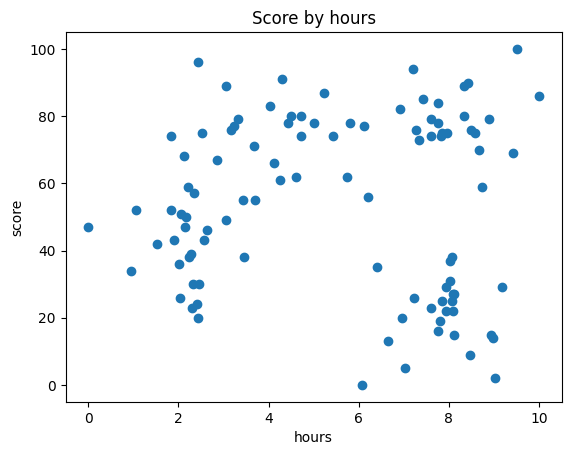

In [ ]:
plt.scatter(X[:,0], X[:, 1])
plt.title('Score by hours')
plt.xlabel('hours')
plt.ylabel('score')
plt.show()

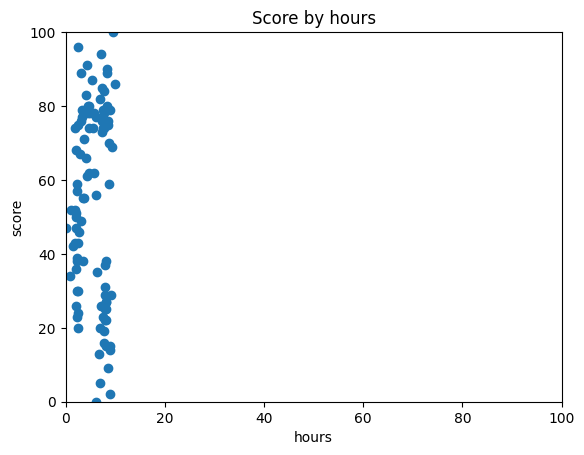

In [ ]:
plt.scatter(X[:,0], X[:, 1])
plt.title('Score by hours')
plt.xlabel('hours')
plt.xlim(0, 100)
plt.ylabel('score')
plt.ylim(0, 100)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X[:5]

array([[ 0.68729921,  0.73538376],
       [-0.66687438,  0.04198891],
       [-0.77161709,  0.04198891],
       [-0.9100271 ,  1.35173473],
       [-0.8090252 ,  0.96651537]])

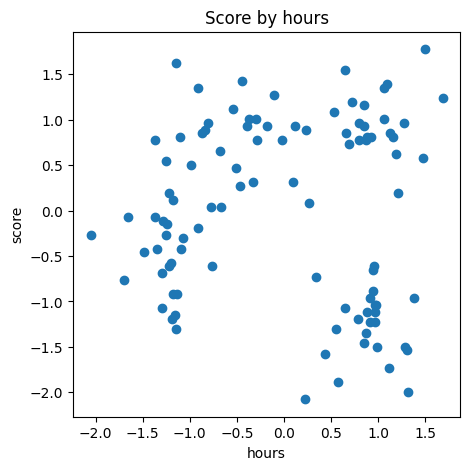

In [ ]:
plt.figure(figsize =(5, 5))
plt.scatter(X[:,0], X[:, 1])
plt.title('Score by hours')
plt.xlabel('hours')
plt.ylabel('score')
plt.show()

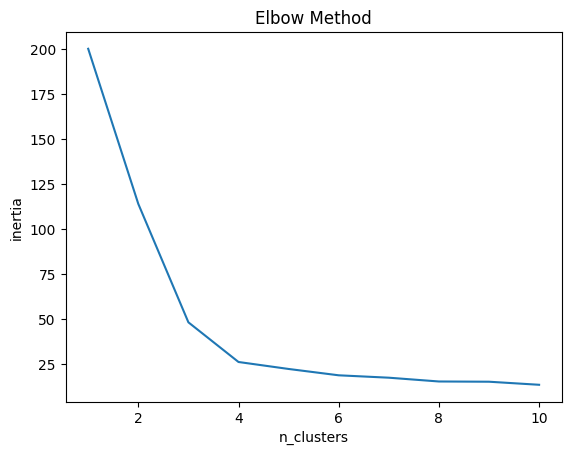

In [ ]:
from sklearn.cluster import KMeans
inertia_list = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(X)
    inertia_list.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia_list)
plt.title('Elbow Method')
plt.xlabel('n_clusters')
plt.ylabel('inertia')
plt.show()

In [ ]:
K=4
kmeans = KMeans(n_clusters=K, random_state=0)
y_kmeans = kmeans.fit_predict(X)

In [ ]:
y_kmeans

array([1, 0, 3, 0, 0, 2, 2, 0, 1, 0, 0, 3, 2, 3, 3, 0, 2, 1, 3, 0, 2, 0,
       3, 2, 1, 1, 3, 3, 3, 3, 2, 2, 3, 0, 1, 1, 3, 0, 0, 0, 3, 2, 1, 3,
       3, 1, 2, 0, 2, 2, 1, 0, 2, 2, 0, 0, 0, 0, 3, 2, 2, 1, 1, 1, 1, 2,
       2, 0, 2, 1, 3, 1, 1, 1, 3, 3, 3, 3, 0, 1, 2, 1, 2, 2, 1, 0, 3, 2,
       1, 3, 0, 2, 0, 1, 3, 0, 1, 0, 2, 3], dtype=int32)

In [ ]:
centers = kmeans.cluster_centers_
centers

array([[-0.54299598,  0.79316666],
       [ 0.96910697,  0.97133061],
       [ 0.8837666 , -1.26929779],
       [-1.24939347, -0.48807293]])

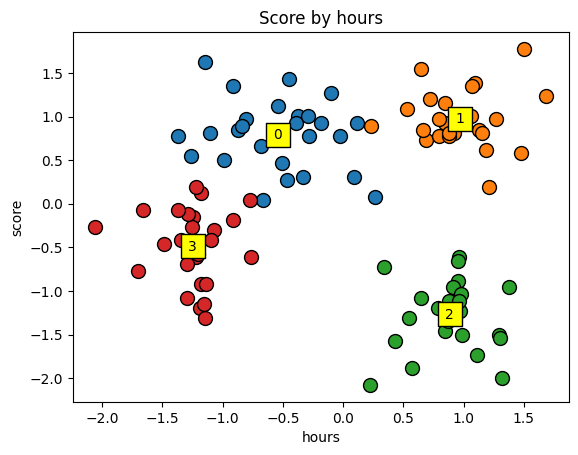

In [ ]:
for cluster in range(K):
    plt.scatter(X[y_kmeans == cluster, 0], X[y_kmeans == cluster, 1], s=100, edgecolor='black')
    plt.scatter(centers[cluster, 0], centers[cluster, 1], s=300, edgecolor='black', color='yellow', marker='s')
    plt.text(centers[cluster, 0], centers[cluster, 1], cluster, va='center', ha='center')

plt.title('Score by hours')
plt.xlabel('hours')
plt.ylabel('score')
plt.show()

In [ ]:
X_org = sc.inverse_transform(X)
X_org[:5]

array([[ 7.33, 73.  ],
       [ 3.71, 55.  ],
       [ 3.43, 55.  ],
       [ 3.06, 89.  ],
       [ 3.33, 79.  ]])

In [ ]:
centers_org = sc.inverse_transform(centers)
centers_org

array([[ 4.04115385, 74.5       ],
       [ 8.08333333, 79.125     ],
       [ 7.8552    , 20.96      ],
       [ 2.1528    , 41.24      ]])

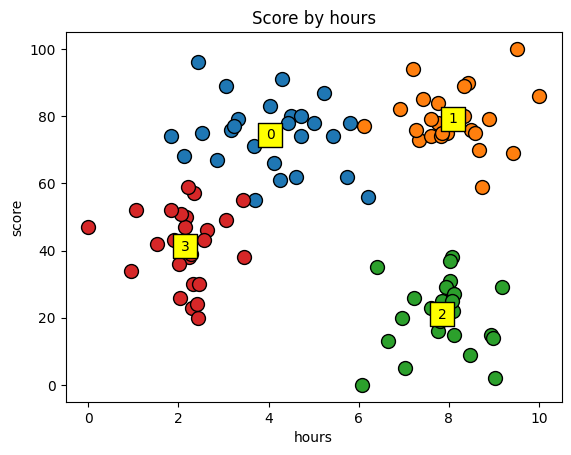

In [ ]:
for cluster in range(K):
    plt.scatter(X_org[y_kmeans == cluster, 0], X_org[y_kmeans == cluster, 1], s=100, edgecolor='black')
    plt.scatter(centers_org[cluster, 0], centers_org[cluster, 1], s=300, edgecolor='black', color='yellow', marker='s')
    plt.text(centers_org[cluster, 0], centers_org[cluster, 1], cluster, va='center', ha='center')

plt.title('Score by hours')
plt.xlabel('hours')
plt.ylabel('score')
plt.show()